In [1]:
import os
from SimpleITK.SimpleITK import And
import numpy as np
import scipy
import SimpleITK as sitk
import matplotlib.pyplot as plt
from skimage.segmentation import join_segmentations
import pandas as pd


In [39]:
def GetSlices(seg_arr):
    values= []
    for i in range(0,len(seg_arr)):
        val = np.sum(seg_arr[i,:,:])
        if val >=  20000 :
            values.append(i)
    return values

def GetSlicesArray(masks):
    slices_array =[]
    for image in masks:
        slices = GetSlices(image)
        slices_array.append((slices))
    return np.asarray(slices_array)

def GetArea(seg_arr, staple_slices, patient):
    values = []
    for i in staple_slices[patient]:
        
        val = np.sum(seg_arr[i,:,:])
        
        val/255
        values.append(val.astype(int))
    return values
def GetAreaArray(masks, masks_ids, staple_id, staple_slices):
    area_array =[]
    masks_ids_l = masks_ids.tolist()
    for id in staple_id:
       
        place_holder = masks_ids_l.index(id)
        
        areas = GetArea(masks[place_holder], staple_slices, place_holder)
        area_array.append(areas)
    return np.asarray(area_array)


def StapleGun(masks_a, masks_b, masks_c, ids_a, ids_b, ids_c):

    slices_array_a = GetSlicesArray(masks_a)
    slices_array_b = GetSlicesArray(masks_b)
    slices_array_c = GetSlicesArray(masks_c)
    """
    #removed CR slices, for when I have all of the data sheets 
    path_a = "path"
    path_b = "path"
    path_c = "path"
    slices_array_a = RemoveCoronaRadiataSlices(masks_a, ids_a, path_a)
    slices_array_b = RemoveCoronaRadiataSlices(masks_b, ids_b, path_b)
    slices_array_c = RemoveCoronaRadiataSlices(masks_c, ids_c, path_c) 
    """

    staple_array = []
    slices_array = []
    id = []
    id_ticker = 0
    

    for i in range (0, 77) :
        id_ticker += 1
        staple_slices_array = []  
        slices_id =[]
        patient_id = ids_a[i]

        for j in slices_array_a[i]:
            if j in slices_array_b[i] and j in slices_array_c[i]:

                masks_a[i][j][masks_a[i][j]==255] = 1
                masks_b[i][j][masks_b[i][j]==255] = 1
                masks_c[i][j][masks_c[i][j]==255] = 1

                mask_a = sitk.GetImageFromArray(masks_a[i][j])
                mask_b = sitk.GetImageFromArray(masks_b[i][j])
                mask_c = sitk.GetImageFromArray(masks_c[i][j])
                

                staple_filter = sitk.STAPLEImageFilter()
                staple_filter.SetForegroundValue(1)
                staple_image = staple_filter.Execute(mask_a,mask_b, mask_c)
                staple_image = staple_image > 0.5                                
                staple_slice_array = sitk.GetArrayFromImage(staple_image)
                iter = staple_filter.GetElapsedIterations()
                print("Patient: ", i, ", Slice: ", j)
                print("iter: ", iter)

                staple_slices_array.append(staple_slice_array)
                slices_id.append(j)
                
        id.append((patient_id))
        staple_array.append(staple_slices_array)
        slices_array.append(slices_id)
        
    return staple_array, id, slices_array

def UnpackNpz(path):
    data = np.load(path, allow_pickle=True)
    masks = data['masks']
    ids = data['ids']
    return masks, ids

def OnesNZeros(mask_array):
    mask_array_copy = mask_array
    slices_array = GetSlicesArray(mask_array_copy)
    for i in range(0, len(mask_array_copy)):
        for slic in slices_array[i]:
            mask_array_copy[i][slic][mask_array_copy[i][slic]==255] = 1
    return mask_array_copy

def HasCoronaRadiata(csv_path):
    data_frame = pd.read_excel(csv_path, sheet_name='Sheet1', usecols = ['PRIME_ID ', 'CR_distance_to_hematoma_(mm)'])
    
    CR =data_frame['CR_distance_to_hematoma_(mm)'].tolist()
    ids = data_frame['PRIME_ID '].tolist()
    ind = []
    for i in range(0,len(CR)):
        if CR[i] !=0:
            ind.append(i)
    patients=[]
    for i in ind:
        patient = ids[i][0:4]
        patients.append(patient)

    return np.asarray(patients, dtype = int)

def RemoveCoronaRadiataSlices(mask_array, mask_ids, csv_path):
    mask_ids_dummy = mask_ids.astype(int).tolist()
    patients = HasCoronaRadiata(csv_path)
    slices_array = GetSlicesArray(mask_array)
    for id in patients:
        if id in mask_ids_dummy:
            
            ind = mask_ids_dummy.index(id)
            length= len(slices_array[ind])
            if id != 0:
             slices_array[ind].pop(length-1)
         
    return slices_array

  


def IdSkip(ids_a,ids_b,ids_c, masks_a, masks_b, masks_c):
    mask_a = masks_a.tolist()
    mask_b = masks_b.tolist()
    mask_c = masks_c.tolist()
    id_a = ids_a.tolist()
    id_b = ids_b.tolist()
    id_c = ids_c.tolist()
    ids_skip =[]
    for id in ids_a:
        if id not in ids_b or id not in ids_c:
            ids_skip.append(id)
    for id in ids_skip:
        if id in ids_a:
            i = id_a.index(id)
            mask_a.pop(i)
            id_a.pop(i)

        if id in ids_b:
            i = id_b.index(id)
            mask_b.pop(i)
            id_b.pop(i)

        if id in ids_c:
            i = id_c.index(id)
            mask_c.pop(i)
            id_c.pop(i)

    return np.asarray(mask_a), np.asarray(id_a), np.asarray(mask_b), np.asarray(id_b), np.asarray(mask_c), np.asarray(id_c)

def dice_loss(input, target):
    
    smooth = 1.

    iflat = input.view(-1)
    tflat = target.view(-1)
    print("iflat: ", iflat, "tflat: ", tflat)
    intersection = (iflat * tflat).sum(-1)
    print(intersection)
    print(iflat.sum(-1) + tflat.sum(-1))
    return ((2. * intersection + smooth) /
              (iflat.sum(-1) + tflat.sum(-1) + smooth))


def compute_dice_coefficient(mask_pred, mask_gt):

  volume_sum = mask_gt.sum() + mask_pred.sum()
  if volume_sum == 0:
    return np.NaN
  volume_intersect = (mask_gt & mask_pred).sum()
  return 2*volume_intersect / volume_sum 

def DiceCaster(staple_array, staple_ids, staple_slices, masks_a, ids_a):
    
    id_a = ids_a.tolist()
    dice_array =[]
    for i in range(0, len(staple_array)):
        dices_array =[]
        for j in range(0, len(staple_array[i])):
            patient_id = staple_ids[i]
            slices_arr = staple_slices[i]
            place_holder = id_a.index(patient_id)
            ind = slices_arr[j]
            
            #print("place holder: ", place_holder, "ind: ", ind, "i: ", i, "j: ", j )
            dice_coeff = compute_dice_coefficient(masks_a[place_holder][ind,:,:], staple_array[i][j])
            dices_array.append(dice_coeff)
        dice_array.append(dices_array)   
    return dice_array

def AverageDice(dice_array):
    average = []
    for patient in dice_array:
        cleanedList = [x for x in patient if str(x) != 'nan']
        sum= np.sum(cleanedList)
        length = len(cleanedList)
        avg = sum/length
        average.append(avg)

    cleanedAverage = [x for x in average if str(x) != 'nan']
    length = len(cleanedAverage)
    sum = np.sum(cleanedAverage)
    total_avg = sum/length
    return total_avg, average

def GetSliceOverlap(slices_a, ids_a, slices_b, ids_b, slices_c, ids_c):
    percent = []
    
    total_intersection = 0
    total_union = 0
    for i in ids_a:
        ind_a = ids_a.tolist().index(i)
        ind_p= ids_b.tolist().index(i)
        ind_s = ids_c.tolist().index(i)
        print(ind_a, ind_p, ind_s)
        intersection = set(slices_a[ind_a]) & set(slices_b[ind_p]) & set(slices_c[ind_s])
        union = set(slices_a[ind_a])|set(slices_b[ind_p])|set(slices_c[ind_s])
        smooth = 0.001
        percentage = len(intersection)/(len(union)+smooth)
        percent.append(percentage)
        total_intersection += len(intersection)
        total_union += len(union)

    total_percentage = total_intersection/total_union
    return total_percentage, percent
    
    



In [3]:
adrian_path = '/Users/olivia/Documents/PhD/MISTIE/mask_data/adrian_masks.npz'
sacha_path = '/Users/olivia/Documents/PhD/MISTIE/mask_data/sacha_masks.npz'
paul_path = '/Users/olivia/Documents/PhD/MISTIE/mask_data/paul_masks.npz'

masks_paul, ids_paul = UnpackNpz(paul_path)
masks_adrian, ids_adrian = UnpackNpz(adrian_path)
masks_sacha, ids_sacha = UnpackNpz(sacha_path)


In [7]:
slices_a = GetSlicesArray(new_mask_adrian)
slices_p =GetSlicesArray(new_mask_paul)
slices_s = GetSlicesArray(new_mask_sacha)


/var/folders/j9/4t_m1wxx3lnbsv72kfd1kgzc0000gr/T/ipykernel_70036/1662457066.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(slices_array)


/var/folders/j9/4t_m1wxx3lnbsv72kfd1kgzc0000gr/T/ipykernel_70036/3039047884.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(area_array)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/collections.py:1099: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


0.7980787699826042 0.7923921981399258 0.6266002833611524


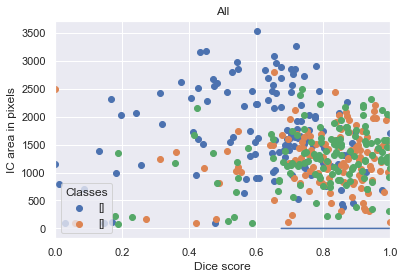

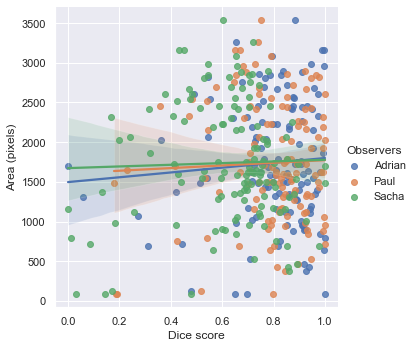

In [89]:

#masks_paul_01 = OnesNZeros(new_masks_paul)
areas_s = GetAreaArray(new_mask_sacha, new_id_sacha, staple_ids, staple_slices)
areas_a = GetAreaArray(new_mask_adrian, new_id_adrian, staple_ids, staple_slices)
areas_p = GetAreaArray(new_mask_paul, new_id_paul, staple_ids, staple_slices)

"""
area_df = pd.DataFrame(areas,index = staple_ids)
area_df.index.name = "Patient ID"
with pd.ExcelWriter('/Users/olivia/Documents/PhD/MISTIE/mask_data/area.xlsx') as writer:  
    area_df.to_excel(writer, sheet_name='area')
"""
flattened_s = []
area_flat_s =[]
dice_flat_s =[]
for i in range(0, len(areas_s)):
    for j in range(0, len(areas_s[i])):
        flat = (dice_array_sacha[i][j],areas_s[i][j] )
        dice = dice_array_sacha[i][j]
        area = areas_s[i][j]
        dice_flat_s.append(dice)
        area_flat_s.append(area)
        flattened_s.append(flat)

flattened_a = []
area_flat_a =[]
dice_flat_a =[]
for i in range(0, len(areas_a)):
    for j in range(0, len(areas_a[i])):
        flat = (dice_array_adrian[i][j],areas_a[i][j] )
        dice = dice_array_adrian[i][j]
        area = areas_s[i][j]
        dice_flat_a.append(dice)
        area_flat_a.append(area)
        flattened_a.append(flat)
flattened_p = []
area_flat_p =[]
dice_flat_p =[]
for i in range(0, len(areas_p)):
    for j in range(0, len(areas_p[i])):
        flat = (dice_array_paul[i][j],areas_p[i][j] )
        dice = dice_array_paul[i][j]
        area = areas_s[i][j]
        dice_flat_p.append(dice)
        area_flat_p.append(area)
        flattened_p.append(flat)

s = plt.scatter(*zip(*flattened_s))
a = plt.scatter(*zip(*flattened_a))
p = plt.scatter(*zip(*flattened_p))
plt.plot(np.unique(flattened_s[0]), np.poly1d(np.polyfit(flattened_s[0], flattened_s[1], 1))(np.unique(flattened_s[0])))
plt.xlim(0,1)
plt.title("All")
plt.xlabel("Dice score" )
plt.ylabel("IC area in pixels")
plt.legend(p.legend_elements(),
                    loc="lower left", title="Classes")
#plt.show
dices = dice_flat_a + dice_flat_p + dice_flat_s
#dicess.append(flattened_s)
print((sum(dice_flat_a)/len(dice_flat_a)), (sum(dice_flat_p)/len(dice_flat_p)), (sum(dice_flat_s)/len(dice_flat_s)))
areas = area_flat_a + area_flat_p + area_flat_s

adrians =  ["Adrian"]* 131
pauls = ["Paul"]*131
sachas = ["Sacha"]*131
observers = adrians + pauls + sachas


total_dataframe = pd.DataFrame(dices, columns= ["Dice"])
total_dataframe["Areas"] = areas
total_dataframe["Observers"] = observers

import seaborn as sns
sns.set_theme()

# Load the penguins dataset
penguins = sns.load_dataset("penguins")

# Plot sepal width as a function of sepal_length across days
g = sns.lmplot(
    data = total_dataframe,
    x="Dice", y="Areas", hue = "Observers"
)

# Use more informative axis labels than are provided by default
g.set_axis_labels("Dice score", "Area (pixels)")


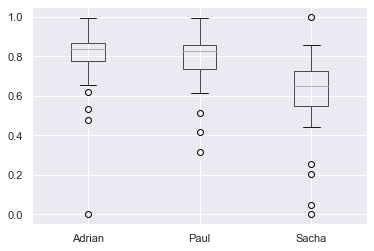

In [73]:
#plt.boxplot(flattened_a)
data = [adrian_patient_avg, sacha_patient_avg, paul_patient_avg]

df = pd.DataFrame(adrian_patient_avg, columns = ['Adrian'])
df['Paul'] = paul_patient_avg
df['Sacha'] = sacha_patient_avg
boxplot = df.boxplot() 

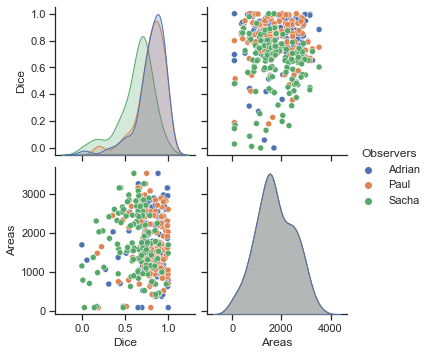

In [91]:
import seaborn as sns
sns.set_theme(style="ticks")


sns.pairplot(total_dataframe, hue="Observers")

In [5]:


new_mask_paul,new_id_paul,new_mask_adrian,new_id_adrian,new_mask_sacha,new_id_sacha = IdSkip(ids_paul, ids_adrian, ids_sacha, masks_paul, masks_adrian, masks_sacha)


/var/folders/j9/4t_m1wxx3lnbsv72kfd1kgzc0000gr/T/ipykernel_70036/1662457066.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(mask_a), np.asarray(id_a), np.asarray(mask_b), np.asarray(id_b), np.asarray(mask_c), np.asarray(id_c)


In [ ]:
new_mask_adrian_copy = new_mask_adrian
new_mask_paul_copy = new_mask_paul
new_mask_sacha_copy = new_mask_sacha
new_mask_adrian10 = OnesNZeros(new_mask_adrian_copy)
new_mask_paul10 = OnesNZeros(new_mask_paul_copy)
new_mask_sacha10 = OnesNZeros(new_mask_sacha_copy)

In [11]:
staple_array, staple_ids, staple_slices = StapleGun(masks_a= new_mask_adrian, masks_b= new_mask_paul, masks_c= new_mask_sacha, ids_a= new_id_adrian, ids_b = new_id_paul, ids_c= new_id_sacha)

/var/folders/j9/4t_m1wxx3lnbsv72kfd1kgzc0000gr/T/ipykernel_70036/982053395.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(slices_array)


Patient:  0 , Slice:  26
iter:  23
Patient:  1 , Slice:  16
iter:  41
Patient:  1 , Slice:  17
iter:  33
Patient:  1 , Slice:  19
iter:  12
Patient:  2 , Slice:  14
iter:  26
Patient:  2 , Slice:  15
iter:  22
Patient:  2 , Slice:  17
iter:  18
Patient:  3 , Slice:  16
iter:  21
Patient:  3 , Slice:  17
iter:  40
Patient:  3 , Slice:  19
iter:  14
Patient:  4 , Slice:  13
iter:  103
Patient:  4 , Slice:  14
iter:  53
Patient:  4 , Slice:  15
iter:  61
Patient:  7 , Slice:  11
iter:  22
Patient:  7 , Slice:  12
iter:  22
Patient:  7 , Slice:  15
iter:  38
Patient:  10 , Slice:  15
iter:  24
Patient:  10 , Slice:  18
iter:  21
Patient:  11 , Slice:  15
iter:  35
Patient:  11 , Slice:  16
iter:  20
Patient:  11 , Slice:  17
iter:  13
Patient:  11 , Slice:  18
iter:  15
Patient:  14 , Slice:  16
iter:  32
Patient:  14 , Slice:  17
iter:  23
Patient:  15 , Slice:  26
iter:  77
Patient:  15 , Slice:  27
iter:  168
Patient:  15 , Slice:  28
iter:  116
Patient:  17 , Slice:  11
iter:  101
Pati

In [ ]:
masks_adrian_copy = masks_adrian

masks_adrian_01 = OnesNZeros(masks_adrian_copy)
print(np.unique(masks_adrian_01[1][17]))
print((masks_adrian_01[1]).shape)

In [34]:
dice_array_adrian = DiceCaster(staple_array, staple_ids, staple_slices, new_mask_adrian, new_id_adrian)
adrian_total_avg, adrian_patient_avg = AverageDice(dice_array_adrian)

dice_array_paul = DiceCaster(staple_array, staple_ids, staple_slices, new_mask_paul, new_id_paul)
paul_total_avg, paul_patient_avg = AverageDice(dice_array_paul)

dice_array_sacha = DiceCaster(staple_array, staple_ids, staple_slices, new_mask_sacha, new_id_sacha)
sacha_total_avg, sacha_patient_avg = AverageDice(dice_array_sacha)

print("avg adrian: ", adrian_total_avg, "avg paul: ", paul_total_avg, "avg sacha: ", sacha_total_avg)




/var/folders/j9/4t_m1wxx3lnbsv72kfd1kgzc0000gr/T/ipykernel_70036/2730793691.py:216: RuntimeWarning: invalid value encountered in double_scalars
  avg = sum/length


avg adrian:  0.7944444847698146 avg paul:  0.7937012107025789 avg sacha:  0.6181791499478059


In [ ]:
new_slice_adrian = GetSlicesArray(new_mask_adrian)
new_slice_paul = GetSlicesArray(new_mask_paul)
new_slice_sacha = GetSlicesArray(new_mask_sacha)
percent = []
intersections = []
total_intersection = 0
total_union = 0
for i in new_id_adrian:
    ind_a = new_id_adrian.tolist().index(i)
    ind_p= new_id_paul.tolist().index(i)
    ind_s = new_id_sacha.tolist().index(i)
    print(ind_a, ind_p, ind_s)
    intersection = set(new_slice_adrian[ind_a]) & set(new_slice_paul[ind_p]) & set(new_slice_sacha[ind_s])
    print(new_slice_adrian[ind_a], new_slice_paul[ind_p], new_slice_sacha[ind_s])
    print(intersection)
    intersections.append(intersection)
    #union = set(slices_a[i]).union(set(slices_p[i]),set(slices_s[i]) )
    union = set(new_slice_adrian[ind_a])|set(new_slice_paul[ind_p])|set(new_slice_sacha[ind_s])
    smooth = 0.001
    percentage = len(intersection)/(len(union)+smooth)
    print(percentage)
    percent.append(percentage)
    total_intersection += len(intersection)
    total_union += len(union)

total_percentage = total_intersection/total_union
print(total_percentage)

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid
'''
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(x, y)
axs[0, 0].set_title('Axis [0, 0]')
axs[0, 1].plot(x, y, 'tab:orange')
axs[0, 1].set_title('Axis [0, 1]')
axs[1, 0].plot(x, -y, 'tab:green')
axs[1, 0].set_title('Axis [1, 0]')
axs[1, 1].plot(x, -y, 'tab:red')
axs[1, 1].set_title('Axis [1, 1]')
'''
'''
fig,axs = plt.subplots(1, 5)

for i in range(0,77):
    for j in range(0,4):
        axs[0, j].imshow(staple_array[i][j])
    for ax in axs.flat:
        ax.set(xlabel='x-label', ylabel='y-label')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()
'''
for i in range(0,77):
    if len(staple_array[i]) != 0:
        ncols = len(staple_array[i])
        fig = plt.figure(figsize=(10., 10.))
        grid = ImageGrid(fig, 111,  # similar to subplot(111)
                        nrows_ncols=(1, ncols),  # creates 2x2 grid of axes
                        axes_pad=0.5,  # pad between axes in inch.
                        )

        for ax, im in zip(grid, staple_array[i]):
            # Iterating over the grid returns the Axes.
            ax.imshow(im)

        plt.show()

In [ ]:

fig=plt.figure(figsize=(12, 90))
ax = []
rows = 40
columns = 4
#figure with 5 columns

for j in range(0, 75):
  for i in range(0, len(staple_array[j])):
    ax.append(fig.add_subplot(rows, columns, i+1))
    

    plt.imshow(staple_array[j][i], cmap = plt.cm.autumn, alpha = 0.5)
    
    
  
    plt.show()
    
  
